# GPUの利用

## GPU利用のために必要となる設定

### インスタンスタイプ、VMサイズ

GPUが利用できるEC2インスタンスタイプ(Amazon)、VMサイズ(Microsoft Azure)を指定する必要があります。

Amazon EC2 であれば、以下のものが候補になります。

* [p3インスタンス](https://aws.amazon.com/jp/ec2/instance-types/p3/)
* [p2インスタンス](https://aws.amazon.com/jp/ec2/instance-types/p2/)
* [g3インスタンス](https://aws.amazon.com/jp/ec2/instance-types/g3/)

Microsoft Azure VM であれば、以下のものが候補になります。

* [NVシリーズ](https://docs.microsoft.com/ja-jp/azure/virtual-machines/windows/sizes-gpu#nv-series)

### ドライバ、ライブラリなど

GPUを利用するためには、GPUドライバ、ライブラリなどを準備する必要があります。

VCPではGPUドライバなどをVCノードの構成に合わせた形でセットアップしたものを事前に用意してあります。そのため通常のVCノードを利用する場合に`spec`指定を行ったのと同様の手順で、いくつかのパラメータを `spec`に指定するだけでGPUを利用することが出来ます。

GPUを利用しない場合（下図左側）と、GPUを利用する場合（下図右側）のVCノードの構成を以下に示します。

![GPUコンテナ](images/201-001.png)

GPUを利用しない場合との違いを以下に示します。
* OS（マシンイメージ）に nvidia ドライバをインストールしている
* Baseコンテナで[NVIDIA Container Runtime for Docker(nvidia-docker)](https://github.com/NVIDIA/nvidia-docker)を利用できるようにセットアップしている

nvidia ドライバはカーネルモジュールになっているため、VMのカーネルバージョンに強く依存しています。そのためnvidiaドライバはBaseコンテナではなくOS（マシンイメージ）にインストールしています。

## 操作手順

この Notebook では以下の操作を行います。

1. GPU用のVCノードを起動する
1. GPUを利用するアプリケーションコンテナを起動する

# GPU用VCノードを起動する

GPUを利用するために必要となるパラメータを `spec`に指定して、VCノードを起動する。

## アクセストークンの入力

VCP SDKを利用するにはVC Controllerのアクセストークンが必要となります。次のセルを実行すると入力枠が表示されるのでアクセストークンの値を入力してください。

> アクセストークン入力後に Enter キーを押すことで入力が完了します。

In [1]:
from getpass import getpass
vcc_access_token = getpass()

········


## VCP SDKの初期化

VCP SDKの初期化を行います。

In [2]:
from common import logsetting
from vcpsdk.vcpsdk import VcpSDK

# VCの管理オブジェクトの作成
vcp = VcpSDK(
    vcc_access_token,  # VCCのアクセストークン
)

上のセルの実行結果がエラーとなり以下のようなメッセージが表示されている場合は、入力されたアクセストークンに誤りがあります。

```
2018-09-XX XX:XX:XX,XXX - ERROR - config vc failed: http_status(403)
2018-09-XX XX:XX:XX,XXX - ERROR - 2018/XX/XX XX:XX:XX UTC: VCPAuthException: xxxxxxx:token lookup is failed: permission denied
```

この場合はアクセストークンの入力からやり直してください。

## VCノードのspecを指定する

GPUを利用するVCノードのspecを指定します。

### specの取得

プロバイダと `flavor`を指定して `spec`オブジェクトを取得します。ここでは以下の値を指定します。

* プロバイダ: `aws`
* flavor: `gpu`

`flavor` に `gpu` を指定することで、GPUが利用できるインスタンスタイプが選択されます。

In [3]:
spec = vcp.get_spec(
    'aws',    # プロバイダ
    'gpu'  # flavor
)

GPUを利用するための nvidiaドライバや、GPUコンテナを実行するためのランタイム（[nvidia-docker2](https://github.com/NVIDIA/nvidia-docker)）を準備したVMイメージ、Baseコンテナイメージを `spec` の設定に追加します。

In [4]:
# Baseコンテナイメージの設定
spec.image = 'vcp/gpu:1.6.2-gpusopt'
# 仮想マシンイメージの設定
spec.cloud_image = 'niivcp-gpu-a-21.04.0-r0'

### sshの鍵ファイルを設定する

VCノードにsshでログインするためには事前に公開鍵認証の鍵を登録する必要があります。そのための設定をここで行います。

VCノードに登録する公開鍵認証の**公開鍵**のパスを次のセルで指定してください。

In [5]:
import os
ssh_public_key = os.path.expanduser('~/.ssh/id_rsa.pub')

指定した公開鍵を `spec` に設定します。

In [6]:
spec.set_ssh_pubkey(ssh_public_key)

後でVCノードにSSHでログインする際に秘密鍵も必要になるので、ここで設定しておきます。次のセルで**秘密鍵**のパスを指定してください。

In [7]:
ssh_private_key = os.path.expanduser('~/.ssh/id_rsa')

公開鍵と秘密鍵が正しいペアであることをチェックします。次のセルを実行してエラーにならないことを確認してください。

In [8]:
!grep -q "$(ssh-keygen -y -f {ssh_private_key})" {ssh_public_key}

### specの設定内容の確認

ここまで `spec` に設定した内容を確認してみます。

In [9]:
print(spec)


aws
------------------------

    cci_version: "1.1"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/gpu:1.6.2-gpusopt
    recovery_mode: none
    docker_opt: {}
    params:
        {'v': [], 'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDc09nTzdmTXJMSG5yRkpSZFROVkVOaWRDNlJTYlNYSE94dmxzSWUvMWc3Nk9IdXB5TE9EUUJ5aXhHc2t1QlVkaXBPaElGV3doeUR4RFRVMU9Xb1BLbHhuTndiV29oZXh1T2s3bmtCYmJ6Y09hT2hhZW5EL1RVdGVLeU05Tm85SW5PTktyS3lTQ0pQVklCUklTVlNXenF6ZzM4NENzSkNNVVBXdVNRcnZmNFpXajI3TDZCYUdaa0c2elVYaVVmMzAvZSsvcitrV2NIZFNFUUcyUHhqRk1iWU9aQkZSMzR5K1RuaWlpTE5LNFlXODgvajdFbXBCRGZ2VEtzL0ZLTXd3WjRjWkdqbmx6eWxFOEdldGhVNC9zcWFYQ1dZSWtHOFJzSjQ2MzRLNU5uTkdRSG80WEZPRzQ0TEJFdkhRTlJoajZCSU14eGd5TkgxVFZlUTdFT2RZNG4gdXNlcjUxMXhlNWIwNTJAMGVhNDIwMGNjMDUxCg==']}

    instance_type: g3.4xlarge
    volume_size: 40
    volume_type: gp2
    volume_id: []
    cloud_image: niivcp-gpu-a-21.04.0-r0
    ip_address_list: []
    tags: {}


## VCノードの起動

VCノードの起動と、VCノードを操作するためのAnsible設定を行います。

### Unitの作成とVCノードの起動

Unitの作成とVCノードの起動を行います。

まずはUnitGroupを作成します。UnitGroupの名前は `handson201`とします。

In [10]:
unit_group = vcp.create_ugroup(
    'handson201'                   # UnitGroupの名前
)

VCノードを起動する前のUnitとVCノードの状態を確認しておきます。

In [11]:
from IPython.display import display

# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# VCノードの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state


[]

Unitの作成とVCノードの起動を行います。

> 処理が完了するまで2分～7分程度かかります。

In [12]:
# Unitの作成（同時に VCノードが作成される）
unit_group.create_unit(
    'gpu',         # Unit名
    spec
)

2021-07-05 22:50:03,794 - INFO - BOOTING ... 0 sec
2021-07-05 22:50:08,934 - INFO - BOOTING ... 5 sec
2021-07-05 22:50:14,128 - INFO - BOOTING ... 10 sec
2021-07-05 22:50:19,264 - INFO - BOOTING ... 15 sec
2021-07-05 22:50:24,390 - INFO - BOOTING ... 20 sec
2021-07-05 22:50:29,542 - INFO - BOOTING ... 25 sec
2021-07-05 22:50:34,668 - INFO - BOOTING ... 30 sec
2021-07-05 22:50:39,868 - INFO - BOOTING ... 35 sec
2021-07-05 22:50:45,007 - INFO - BOOTING ... 40 sec
2021-07-05 22:50:50,156 - INFO - BOOTING ... 45 sec
2021-07-05 22:50:55,302 - INFO - BOOTING ... 50 sec
2021-07-05 22:51:00,451 - INFO - BOOTING ... 55 sec
2021-07-05 22:51:05,582 - INFO - BOOTING ... 60 sec
2021-07-05 22:51:10,708 - INFO - BOOTING ... 65 sec
2021-07-05 22:51:15,857 - INFO - BOOTING ... 70 sec
2021-07-05 22:51:21,000 - INFO - BOOTING ... 75 sec
2021-07-05 22:51:26,150 - INFO - BOOTING ... 80 sec
2021-07-05 22:51:31,309 - INFO - BOOTING ... 85 sec
2021-07-05 22:51:36,496 - INFO - BOOTING ... 90 sec
2021-07-05 22:

起動したUnit, VCノードの一覧を表示します。

In [13]:
# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# VCノードの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,6,handson201,RUNNING,b1a3fb8d...,2021/07/05 13:49:42 UTC,gpu,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,6,handson201,gpu,RUNNING,1,06a52d37...,RUNNING,172.30.2.38,i-04c13ebcc5325405b,VCP-8dbe841c-b1a3fb8d,none


### 疎通確認

起動した VC ノードに SSHでログイン出来ることを確認します。

まず、VCノードのIPアドレスを確認します。

In [14]:
ip_address = unit_group.find_ip_addresses(node_state='RUNNING').pop()
print(ip_address)

172.30.2.38


ping による疎通確認を行います。

In [15]:
# NIIのハンズオン環境ではネットワーク構成の事情により本NotebookからVCノードへのping実行はできません。
# !ping -c 4 {ip_address}

VCノードにSSHでログインする準備としてVCノードのホストキーを ~/.ssh/known_hosts に登録します。

In [16]:
!touch ~/.ssh/known_hosts
# ~/.ssh/known_hosts から古いホストキーを削除する
!ssh-keygen -R {ip_address}
# ~/.ssh/known_hostsにVCノードを登録する
!ssh-keyscan -H {ip_address} >> ~/.ssh/known_hosts

Host 172.30.2.38 not found in /home/jovyan/.ssh/known_hosts


VCノードにSSHでログインをしてコマンドを実行してみます。

In [17]:
!ssh root@{ip_address} ls -la

total 28
drwx------ 1 root root 4096 Mar 22 11:36 .
drwxr-xr-x 1 root root 4096 Jul  5 13:53 ..
-rw-r--r-- 1 root root 3106 Dec  5  2019 .bashrc
drwxr-xr-x 1 root root 4096 Jul  5 13:53 .cache
drwxr-xr-x 1 root root 4096 Mar 22 11:36 go
-rw-r--r-- 1 root root  161 Dec  5  2019 .profile
drwx------ 1 root root 4096 Jul  5 13:53 .ssh


# GPU環境の確認

NVIDIA GPUではGPUデバイスを管理、監視するためのコマンド[nvidia-smi](https://developer.nvidia.com/nvidia-system-management-interface)が提供されています。ここでは、起動したVCノードのGPUに関する状態を取得するために`nvidia-smi`コマンドを実行してみます。

`nvidia-smi` コマンドを利用するとGPU名やドライババージョン、GPUメモリ使用量、GPU使用率、GPUの温度などのGPUに関する情報を取得することができます。`nvidia-smi`コマンドが表示するサマリ情報の例を以下に示します。

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   51C    P0    59W / 149W |      0MiB / 11439MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+
```

`nvidia-smi`コマンドは[CUDAコンテナ](https://hub.docker.com/r/nvidia/cuda/)の中で実行するので、まずコンテナイメージの取得を行います。

> コンテナイメージの取得に１～３分程度かかります。

In [18]:
!ssh root@{ip_address} docker pull nvidia/cuda:8.0-cudnn5-runtime-ubuntu16.04

8.0-cudnn5-runtime-ubuntu16.04: Pulling from nvidia/cuda
80bce60046fa: Pulling fs layer
55a738a15540: Pulling fs layer
e19cf0706c62: Pulling fs layer
de4cdd6c27d1: Pulling fs layer
4f3c4703a2b4: Pulling fs layer
17ed76b2effe: Pulling fs layer
cbb7d880cc0b: Pulling fs layer
b27a397de7dd: Pulling fs layer
c88ae169c33a: Pulling fs layer
8532c5e4fd89: Pulling fs layer
cbb7d880cc0b: Waiting
8532c5e4fd89: Waiting
b27a397de7dd: Waiting
c88ae169c33a: Waiting
de4cdd6c27d1: Waiting
4f3c4703a2b4: Waiting
17ed76b2effe: Waiting
e19cf0706c62: Verifying Checksum
e19cf0706c62: Download complete
55a738a15540: Verifying Checksum
55a738a15540: Download complete
de4cdd6c27d1: Verifying Checksum
de4cdd6c27d1: Download complete
4f3c4703a2b4: Verifying Checksum
4f3c4703a2b4: Download complete
cbb7d880cc0b: Download complete
80bce60046fa: Verifying Checksum
80bce60046fa: Download complete
b27a397de7dd: Verifying Checksum
b27a397de7dd: Download complete
c88ae169c33a: Verifying Checksum
c88ae169c33a: Download c

実際にCUDAコンテナから`nvidia-smi` コマンドを実行してGPUに関するサマリ情報が表示させてみます。

> コンテナを実行する際に`docker run`コマンドの引数に`--gpus all`オプションを追加しています。このオプションを指定することで、コンテナ内からGPUを利用するための処理が [nvidia-container-runtime](https://github.com/NVIDIA/nvidia-container-runtime) によって実行されています。

In [19]:
!ssh root@{ip_address} docker run --gpus all --rm \
    nvidia/cuda:8.0-cudnn5-runtime-ubuntu16.04 nvidia-smi

Mon Jul  5 13:54:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   27C    P8    14W / 150W |      0MiB /  7618MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

GPUに関する詳細情報を取得するために `--query`オプションを指定して `nvidia-smi` コマンドを実行してみます。

> `nvidia-smi`コマンドの他のオプションについては [nvidia-smi documentation](http://developer.download.nvidia.com/compute/DCGM/docs/nvidia-smi-367.38.pdf)を参照してください。

In [20]:
!ssh root@{ip_address} docker run --gpus all --rm \
    nvidia/cuda:8.0-cudnn5-runtime-ubuntu16.04 nvidia-smi --query


==============NVSMI LOG==============

Timestamp                                 : Mon Jul  5 13:54:39 2021
Driver Version                            : 455.45.01
CUDA Version                              : 11.1

Attached GPUs                             : 1
GPU 00000000:00:1E.0
    Product Name                          : Tesla M60
    Product Brand                         : Tesla
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 0321017015379
    GPU UUID                              : GPU-fa836064-4b40-84ad-e018-e54b

# GPU環境の利用

構築したGPU環境を利用して [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) を実行してみます。OpenPoseは画像、動画から人の体、手、顔、および足のキーポイントを検出するシステムです。

## 準備

起動時のオプションなどを記述した `docker-compose.yml`ファイルをGPU環境に配置します。

OpenPoseのコンテナイメージを作成するための`Dockerfile`とコンテナを起動する際のオプションなどを記述した `run.sh` をGPU環境に配置します。

In [21]:
!scp -r openpose/ root@{ip_address}:.

Dockerfile                                    100% 1142   276.1KB/s   00:00    
docker-compose.yml                            100%  253    62.9KB/s   00:00    
run.sh                                        100%  460   108.8KB/s   00:00    


## OpenPoseコンテナのビルド（取得）と実行

[OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose)をアプリケーションコンテナとして実行します。

In [22]:
!ssh root@{ip_address} 'cat openpose/run.sh'

#! /bin/bash
# docker-composeで--gpusオプションが指定できず動作確認がしにくい。そのためシェルスクリプトにした。
# ポータブル版、サービス版でAppコンテナイメージを共通化するためharborにあるイメージを使用する
docker run -td --gpus all --name openpose -v $PWD/data:/root/data -v $PWD/result:/root/result -v $PWD/result2:/root/result2 harbor.vcloud.nii.ac.jp/vcp/openpose:handson_20.11


In [23]:
#!ssh root@{ip_address} 'cd openpose && docker-compose up -d'
!ssh root@{ip_address} 'cd openpose && sh run.sh'

Unable to find image 'harbor.vcloud.nii.ac.jp/vcp/openpose:handson_20.11' locally
handson_20.11: Pulling from vcp/openpose
22dc81ace0ea: Pulling fs layer
1a8b3c87dba3: Pulling fs layer
91390a1c435a: Pulling fs layer
07844b14977e: Pulling fs layer
b78396653dae: Pulling fs layer
60e8c8e60650: Pulling fs layer
60bcdd4a44b0: Pulling fs layer
58b3ae962738: Pulling fs layer
07844b14977e: Waiting
5217d046ef8d: Pulling fs layer
8e4decdc2422: Pulling fs layer
b78396653dae: Waiting
79b877e2a35a: Pulling fs layer
c2a456d945c3: Pulling fs layer
3653aff6554b: Pulling fs layer
fd29b77c710b: Pulling fs layer
9c27713c696a: Pulling fs layer
db5d7c50228c: Pulling fs layer
60bcdd4a44b0: Waiting
d0563f0dd871: Pulling fs layer
8e4decdc2422: Waiting
58b3ae962738: Waiting
5217d046ef8d: Waiting
79b877e2a35a: Waiting
c2a456d945c3: Waiting
3653aff6554b: Waiting
d0563f0dd871: Waiting
db5d7c50228c: Waiting
fd29b77c710b: Waiting
60e8c8e60650: Waiting
1a8b3c87dba3: Verifying Checksum
1a8b3c87dba3: Download complete

コンテナが起動されたことを確認します。次のセルを実行して`State`が `Up` と表示されていればコンテナの起動に成功しています。

In [24]:
!ssh root@{ip_address} 'docker ps'

CONTAINER ID   IMAGE                                                COMMAND       CREATED         STATUS         PORTS     NAMES
1732b932d395   harbor.vcloud.nii.ac.jp/vcp/openpose:handson_20.11   "/bin/bash"   7 seconds ago   Up 5 seconds             openpose


## OpenPoseの利用

### サンプルの画像を処理する

OpenPoseのサンプル画像を処理してみます。

まず処理前のファイルを格納するディレクトリを作成します。

In [26]:
result_dir = './openpose_result'
!mkdir -p {result_dir}

処理前のファイルを取得します。

In [27]:
!ssh root@{ip_address} \
    'cd openpose && docker cp openpose:/root/openpose/examples/media .'
!scp -r root@{ip_address}:openpose/media {result_dir}

COCO_val2014_000000000459.jpg                 100%  190KB   8.7MB/s   00:00    
COCO_val2014_000000000415.jpg                 100%  115KB   8.4MB/s   00:00    
COCO_val2014_000000000589.jpg                 100%   95KB   8.5MB/s   00:00    
COCO_val2014_000000000192.jpg                 100%  225KB  12.3MB/s   00:00    
COCO_val2014_000000000360.jpg                 100%  116KB   9.7MB/s   00:00    
COCO_val2014_000000000257.jpg                 100%  204KB  12.6MB/s   00:00    
COCO_val2014_000000000488.jpg                 100%  103KB   7.1MB/s   00:00    
COCO_val2014_000000000328.jpg                 100%  156KB  13.0MB/s   00:00    
COCO_val2014_000000000623.jpg                 100%  110KB  11.3MB/s   00:00    
COCO_val2014_000000000294.jpg                 100%   74KB   8.8MB/s   00:00    
COCO_val2014_000000000357.jpg                 100%  128KB  11.6MB/s   00:00    
COCO_val2014_000000000395.jpg                 100%  241KB  15.7MB/s   00:00    
COCO_val2014_000000000564.jpg           

処理前の画像を１つ表示させてみます。

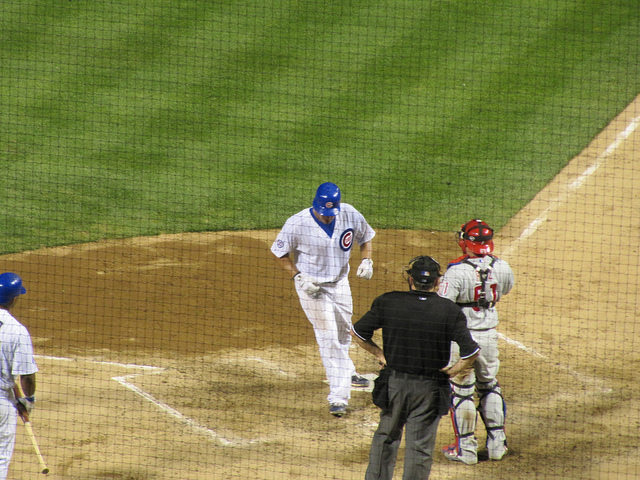

In [28]:
from IPython.display import Image
Image(filename='openpose_result/media/COCO_val2014_000000000192.jpg')

[処理前の画像](./openpose_result/media/)のリンクから他の画像を確認することもできます。

OpenPoseで画像の処理を行います。

In [29]:
!ssh root@{ip_address} 'docker exec -t openpose \
    build/examples/openpose/openpose.bin --display 0 \
    --image_dir examples/media --write_images /root/result \
    --write_images_format jpg'

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 5.461736 seconds.


処理後のファイルを取得します。

In [30]:
!scp -r root@{ip_address}:openpose/result {result_dir}

COCO_val2014_000000000294_rendered.jpg        100%  165KB   7.8MB/s   00:00    
COCO_val2014_000000000395_rendered.jpg        100%  315KB  11.9MB/s   00:00    
COCO_val2014_000000000338_rendered.jpg        100%  154KB  10.6MB/s   00:00    
COCO_val2014_000000000569_rendered.jpg        100%  244KB   8.9MB/s   00:00    
COCO_val2014_000000000459_rendered.jpg        100%  247KB  14.3MB/s   00:00    
COCO_val2014_000000000328_rendered.jpg        100%  273KB  15.2MB/s   00:00    
COCO_val2014_000000000564_rendered.jpg        100%  234KB  14.8MB/s   00:00    
COCO_val2014_000000000544_rendered.jpg        100%  353KB  18.4MB/s   00:00    
COCO_val2014_000000000415_rendered.jpg        100%  166KB  13.1MB/s   00:00    
COCO_val2014_000000000474_rendered.jpg        100%  174KB  13.4MB/s   00:00    
COCO_val2014_000000000192_rendered.jpg        100%  308KB  17.5MB/s   00:00    
COCO_val2014_000000000536_rendered.jpg        100%   76KB   9.2MB/s   00:00    
COCO_val2014_000000000357_rendered.jpg  

OpenPoseで処理した画像を１枚表示させてみます。

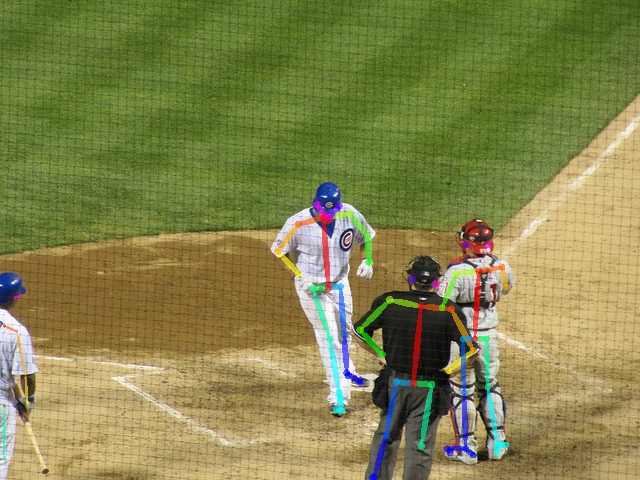

In [31]:
Image(filename='openpose_result/result/COCO_val2014_000000000192_rendered.jpg')

[処理結果](./openpose_result/result/)のリンクから他の処理結果の画像を確認することもできます。

### サンプルの動画を処理する

[処理前の動画](./openpose_result/media/video.avi)を確認します。

In [32]:
from IPython.display import HTML

HTML("""<video style="max-width: 100%;" controls>
  <source src="openpose_result/media/video.avi" />
</video>
""")


OpenPoseのサンプル動画を処理してみます。

> 処理には30秒程度かかります。

In [33]:
!ssh root@{ip_address} 'docker exec -t openpose \
    build/examples/openpose/openpose.bin --display 0 \
    --video /root/openpose/examples/media/video.avi --write_video /root/result/result.avi'

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 22.324248 seconds.


処理結果のファイルを取得します。

In [34]:
!scp -r root@{ip_address}:openpose/result {result_dir}

COCO_val2014_000000000294_rendered.jpg        100%  165KB   9.1MB/s   00:00    
COCO_val2014_000000000395_rendered.jpg        100%  315KB  12.4MB/s   00:00    
COCO_val2014_000000000338_rendered.jpg        100%  154KB  11.2MB/s   00:00    
result.avi                                    100%   17MB  24.7MB/s   00:00    
COCO_val2014_000000000569_rendered.jpg        100%  244KB  19.0MB/s   00:00    
COCO_val2014_000000000459_rendered.jpg        100%  247KB  18.8MB/s   00:00    
COCO_val2014_000000000328_rendered.jpg        100%  273KB  17.8MB/s   00:00    
COCO_val2014_000000000564_rendered.jpg        100%  234KB  18.2MB/s   00:00    
COCO_val2014_000000000544_rendered.jpg        100%  353KB  22.4MB/s   00:00    
COCO_val2014_000000000415_rendered.jpg        100%  166KB  16.0MB/s   00:00    
COCO_val2014_000000000474_rendered.jpg        100%  174KB  16.5MB/s   00:00    
COCO_val2014_000000000192_rendered.jpg        100%  308KB  19.5MB/s   00:00    
COCO_val2014_000000000536_rendered.jpg  

処理後の動画を確認します。

In [35]:
# Notebookに埋め込んで再生する場合に、aviだと再生に失敗するが、mp4に変換すると再生できる。
# mp4に変換
!ffmpeg -i openpose_result/result/result.avi openpose_result/result/result.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [36]:
from IPython.display import HTML

HTML("""<video style="width: 100%;" controls>
  <source src="openpose_result/result/result.mp4" />
</video>
""")


上記で見られない場合は、[処理後の動画 (result.avi)](./openpose_result/result/result.avi)をダウンロードして確認します。

### GrafanaでVCノードの利用状況を確認する

GrafanaでVCノードの利用状況を確認してみます。

In [37]:
vcc_ctr = vcp.vcc_info()['host']
http_host = vcc_ctr.split(':')[0]
grafana_url = "https://{}/grafana/d/vcp/vcp-metrics?refresh=5s".format(http_host)
print(grafana_url)

https://localhost/grafana/d/vcp/vcp-metrics?refresh=5s


> ログインするためのユーザ、パスワードは `admin`/`admin` です。

### インターネット上の画像を処理する

インターネット上の画像を処理してみます。

処理対象となる画像の URL のリストを設定してください。

In [ ]:
image_urls = [
# (例)
#    'http://www.example.com/sample.jpg',
]

処理対象の画像ファイルをOpenPoseコンテナに配置します。

In [ ]:
for url in image_urls:
    !ssh root@{ip_address} 'cd openpose/data && curl -O {url}'

OpenPoseの処理を実行します。

In [ ]:
if len(image_urls) > 0:
    !ssh root@{ip_address} 'docker exec -t openpose \
        build/examples/openpose/openpose.bin --display 0 \
        --image_dir /root/data/ --write_images /root/result2'

処理結果のファイルを取得します。

In [ ]:
!scp -r root@{ip_address}:openpose/result2 {result_dir}

[処理結果](./openpose_result/result2)を確認します。

# 後始末

ビルドしたOpenPoseのイメージをプライベートレジストリに格納する場合は、次のセルのコメントを削除して実行してください。

> 完了するまで2分程度かかります。

In [ ]:
# !ssh root@{ip_address} 'cd openpose && docker-compose push'

全てのリソースを削除します。

> 処理が完了するまで1分～2分程度かかります。

In [38]:
unit_group.cleanup()

2021-07-05 23:00:35,517 - INFO - gpu is DELETING ... 0 sec
2021-07-05 23:00:40,685 - INFO - gpu is DELETING ... 5 sec
2021-07-05 23:00:45,864 - INFO - gpu is DELETING ... 10 sec
2021-07-05 23:00:51,002 - INFO - gpu is DELETING ... 15 sec
2021-07-05 23:00:56,149 - INFO - gpu is DELETING ... 20 sec
2021-07-05 23:01:01,285 - INFO - gpu is DELETING ... 25 sec
2021-07-05 23:01:06,422 - INFO - gpu is DELETING ... 30 sec
2021-07-05 23:01:11,569 - INFO - gpu is DELETING ... 35 sec
2021-07-05 23:01:16,724 - INFO - gpu is DELETING ... 40 sec
2021-07-05 23:01:21,851 - INFO - gpu is DELETING ... 45 sec
2021-07-05 23:01:26,995 - INFO - gpu is DELETING ... 50 sec
2021-07-05 23:01:32,130 - INFO - gpu is DELETING ... 55 sec
2021-07-05 23:01:37,266 - INFO - gpu is DELETING ... 60 sec
2021-07-05 23:01:42,408 - INFO - gpu is DELETING ... 65 sec
2021-07-05 23:01:47,534 - INFO - gpu is DELETING ... 70 sec
2021-07-05 23:01:52,731 - INFO - gpu is DELETING ... 75 sec
2021-07-05 23:01:57,861 - INFO - gpu is DE

ビルドのログがある場合は削除します。

In [39]:
if 'log_file' in locals():
    !rm -f {log_file[1]}

取得した画像ファイルなどを削除します。

In [40]:
!rm -rf {result_dir}